In [1]:
# add path (for local)
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [ ]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import random
import shutil
import time
import torch
from typing import Any
import yaml
from rdkit import RDLogger
from generator import Generator
from language import Language, MolLanguage
from node import SurrogateNode, SentenceNode, MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def read_yaml(yaml_path: str) -> tuple[Generator, dict[str, Any]]:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)
    generator_args = conf.get("generator_args", {})

    # set seed
    if "seed" in conf:
        seed = conf["seed"]
    else:
        seed = int(time.time()) % (2**32)
    logger.info("seed: " + str(seed))
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # set node class
    node_class = class_from_package("node", conf.get("node_class"))
    if node_class == MolSentenceNode:
        MolSentenceNode.use_canonical_smiles_as_key = conf.get("use_canonical_smiles_as_key", False)

    # set transition (and lang if needed)
    transition_args = conf.get("transition_args", {})
    if "model_dir" in transition_args:
        transition_args["model_dir"] = os.path.join(repo_root, transition_args["model_dir"])
    transition_class = class_from_package("transition", conf["transition_class"])
        
    if issubclass(node_class, SentenceNode):
        lang_path = conf.get("lang_path")
        if lang_path is None:
            lang_name = os.path.basename(os.path.normpath(transition_args["model_dir"])) + ".lang"
            lang_path = add_sep(transition_args["model_dir"]) + lang_name
        lang = Language.load(lang_path)
        transition_args["lang"] = lang

    transition = transition_class(logger=logger, device=conf.get("device"), **transition_args)
    
    # set root
    root_args = {}
    if "lang" in locals():
        root_args["lang"] = lang
        
    if type(conf.get("root")) == list:
        root = SurrogateNode()
        for s in conf.get("root"):
            node = node_class.node_from_key(string=s, device=conf.get("device"), **root_args)
            root.add_child(action=s, child=node)
    else:
        root = node_class.node_from_key(string=conf.get("root", ""), device=conf.get("device"), **root_args)

    # set reward
    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_args", {}))
    
    # set policy
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_args", {}))
        generator_args["policy"] = policy

    # set filters
    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
    
    # set generator
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, output_dir=output_dir, logger=logger, **generator_args)

    # copy yaml to the output directory
    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/v3-forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


seed: 1751339875
Starting generation...
<best reward updated> order: 1, time: 0.00, reward: 0.4176, node: Cc1ccc(C[C@H](C)CNC(=O)c2cc(C(N)=O)c(C)cc2C)o1
<best reward updated> order: 3, time: 0.18, reward: 0.6403, node: [NH3+]Cc1cc(S(=O)(=O)N(CC2CC2)C2CC2)co1
<best reward updated> order: 12, time: 0.28, reward: 0.6827, node: Oc1ccc(-n2c(Sc3cnc4ccccc4n3)nnc2-c2ccco2)cc1
<best reward updated> order: 31, time: 0.48, reward: 0.7518, node: COc1cc(NC(=O)CSc2nc3ccccc3s2)ccc1OC(C)C
generated: 100, time: 1.20, average over 100: 0.0497
<best reward updated> order: 191, time: 2.14, reward: 0.7807, node: COc1ccccc1-c1nnc(SCC(=O)Nc2cc(Cl)ccc2C)n1-c1ccccc1
generated: 200, time: 2.24, average over 100: 0.2563
<best reward updated> order: 223, time: 2.48, reward: 0.9422, node: CC[C@H](C)[C@H]([NH3+])C[C@@H](C)C(=O)[O-]
generated: 300, time: 3.20, average over 100: 0.2466
generated: 400, time: 4.15, average over 100: 0.2930
generated: 500, time: 5.06, average over 100: 0.3089
<best reward updated> order

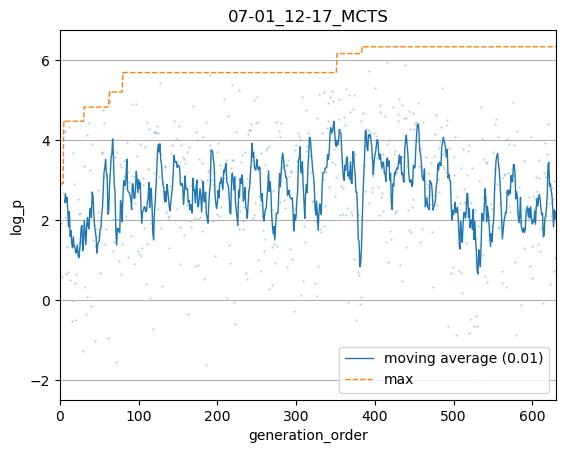

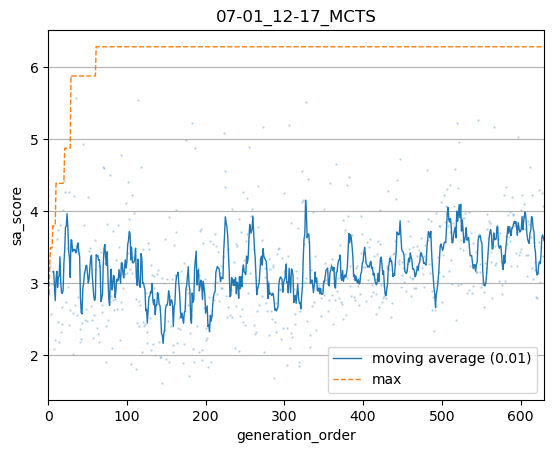

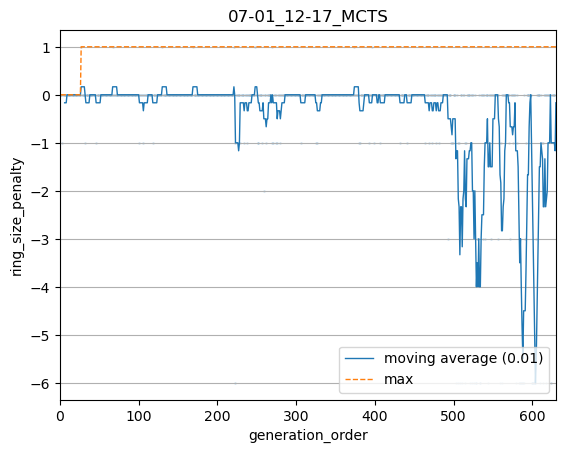

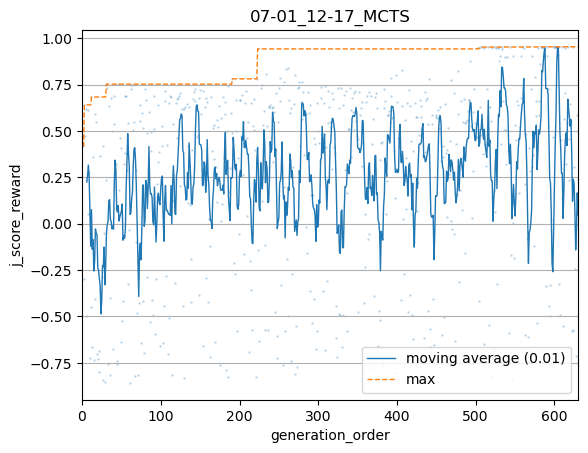

number of generated nodes: 630
valid rate: 0.9675036927621861
unique rate: 0.9630723781388478
node_per_sec: 102.18027012921084
best_reward: 0.9534934082363979
average_reward: 0.26809379249604615


In [3]:
# start generation
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score.yaml"
c6 = "config/mcts_j_score.yaml"
generator, conf = read_yaml(c3)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [16]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load generator and yaml
load_dir = "generation_result/06-26_08-51/"
generator, conf = read_yaml("sandbox/" + load_dir + "setting.yaml")
generator = Generator.load(load_dir + "save.mcts", generator.transition)

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)